## import packages

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

### Load data
- define data transforms (dic)
 - train
 - validation
- load data folder (dic)
 - train
 - validation
- define data loader (dic)
- define numbers of data, classes of data, if_use_GPU

In [4]:
transforms_img = {
    'train': transforms.Compose([
            transforms.RandomSizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    'val': transforms.Compose([
            transforms.Scale(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
}

In [5]:
data_dir = './hymenoptera_data'
dataset = {
    x: ImageFolder(os.path.join(data_dir, x), transform=transforms_img[x]) 
    for x in ['train', 'val']
}

In [6]:
dataloader = {
    x: DataLoader(dataset[x], batch_size=32, shuffle=True, num_workers=2)
    for x in ['train', 'val']
}

In [7]:
datasize = {
    x: len(dataloader[x].dataset)
    for x in ['train', 'val']
}

In [8]:
dataclass = dataloader['train'].dataset.classes

In [9]:
use_gpu = torch.cuda.is_available()

### Visualization
- def imgshow
 - to numpy
 - transpose to (height, width, channel)
 - denormalization

In [10]:
def img_show(img):
    img = img.numpy()
    img = np.transpose(img, [1, 2, 0])
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img = img * std + mean
    plt.imshow(img)

In [11]:
num_show = 4
train_sample = next(iter(dataloader['train']))
img, label = train_sample

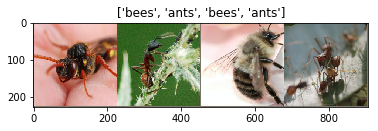

In [12]:
img_show(torchvision.utils.make_grid(img[:num_show], nrow=4))
plt.title([dataclass[i] for i in label[:4]])
plt.show()

### define train module

In [13]:
def train_model(model, criterian, optim_scheduler, num_epoch=25):
    since = time.time()
    
    best_model = model
    best_acc = 0.0
        
    for epoch in range(num_epoch):
        print('{}/{}'.format(epoch+1, num_epoch))
        print('-'*10)
    
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = optim_scheduler(model, epoch+1) # feed model parameters and epoch
                optimizer.zero_grad()
            running_loss = 0.0
            running_acc = 0.0
            for data in dataloader[phase]:
                img, label = data
                if use_gpu:
                    img = Variable(img).cuda()
                    label = Variable(label).cuda()
                else:
                    img = Variable(img)
                    label = Variable(label)
                
                # forward
                output = model(img)
                _, pred = torch.max(output, 1)
                loss = criterian(output, label)
                # backward
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                # log statistics
                running_loss += loss.data[0] * label.size(0)
                num_correct = torch.sum(pred == label)
                running_acc += num_correct.data[0]

            running_loss /= datasize[phase]
            running_acc /= datasize[phase]
            print('{} Loss:{:.4f} Acc:{:.4f}'.format(phase, running_loss, running_acc))
            if phase == 'val' and running_acc > best_acc:
                best_acc = running_acc
                best_model = copy.deepcopy(model)

        print()
    time_eplise = time.time() - since
    print('Traing comlete in {:.0f}m{:.0f}s'.format(time_eplise//60, time_eplise%60))
    print('Best Acc:{:.4f}'.format(best_acc))
    return best_model

In [14]:
def optim_scheduler(model, epoch, init_lr=1e-3, decay_epoch=7):
    lr = init_lr * 0.1 ** (epoch // decay_epoch)
    if epoch % decay_epoch == 0:
        print('learning rate is set {}'.format(lr))
    optimizer = optim.SGD(model.parameters(), lr, momentum=0.9)
    return optimizer

In [15]:
model = resnet18(pretrained=True)
num_fters = model.fc.in_features
model.fc = nn.Linear(num_fters, 2)
if use_gpu:
    model = model.cuda()
criterian = torch.nn.CrossEntropyLoss()

In [16]:
best_model = train_model(model, criterian, optim_scheduler)

1/25
----------
train Loss:0.6519 Acc:0.5574
val Loss:0.3321 Acc:0.8431

2/25
----------
train Loss:0.2961 Acc:0.8934
val Loss:0.2676 Acc:0.9150

3/25
----------
train Loss:0.2806 Acc:0.8852
val Loss:1.0114 Acc:0.5556

4/25
----------
train Loss:0.7061 Acc:0.7049
val Loss:2.9038 Acc:0.5425

5/25
----------
train Loss:1.8406 Acc:0.6352
val Loss:8.2617 Acc:0.4575

6/25
----------
train Loss:3.6357 Acc:0.6598
val Loss:3.9275 Acc:0.5948

7/25
----------
learning rate is set 0.0001
train Loss:4.4840 Acc:0.5738
val Loss:1.7565 Acc:0.7516

8/25
----------
train Loss:2.0983 Acc:0.7008
val Loss:1.1109 Acc:0.8235

9/25
----------
train Loss:1.3040 Acc:0.7910
val Loss:0.7201 Acc:0.8562

10/25
----------
train Loss:0.9760 Acc:0.8361
val Loss:0.4990 Acc:0.9085

11/25
----------
train Loss:0.6046 Acc:0.8934
val Loss:0.5442 Acc:0.9085

12/25
----------
train Loss:0.5832 Acc:0.8975
val Loss:0.4776 Acc:0.9281

13/25
----------
train Loss:0.2579 Acc:0.9426
val Loss:0.5612 Acc:0.9216

14/25
----------
le